# Data Preparation

In [68]:
import numpy as np
import time
from time import time
from torch.autograd import Variable
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import rasterio as rs
from src.sample_tiles import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

import torch
from img2vec_pytorch import Img2Vec
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1. Sample image names

For each biome store the names of each image in an array

### Organise structure for directory iteration

In [60]:
POS_to_CODE = {
    0: 1,
    1: 2,
    2: 3,
}

In [61]:
def one_ugly_encoding(hot_arr):
    hot_arr = np.array(hot_arr)
    ugly_arr = []
    for arr in hot_arr:
        code = POS_to_CODE[np.argmax(arr)]
        ugly_arr.append(code)
    return np.array(ugly_arr)

In [2]:
def normalize_red(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_green(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_blue(array):
    return (array - array.min()) / (array.max() - array.min())

In [3]:
def biome_numerator(biome_DIR):
    biome = biome_DIR.split('/')[-1]

    if biome == "TemporalAmazonia":
        return [1,0,0]
    if biome == "TemporalCerrado":
        return [0,1,0]
    if biome == "TemporalCaatinga":
        return [0,0,1]

    # if biome == "TemporalAmazonia":
    #     return np.zeros((4,51,51,1))
    # if biome == "TemporalCerrado":
    #     return np.ones((4,51,51,1))
    # if biome == "TemporalCaatinga":
    #     return np.full((4,51,51,1), 2)

def get_data():
    X_data = np.zeros((1,4,51,51,3))
    y_data = np.zeros((1,3))
    head_DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-old'

    subfolders = [f.path for f in os.scandir(head_DIR) if f.is_dir()]
    idx = 0
    for biome_DIR in subfolders:
        print ("CUR BIOME: {}".format(biome_DIR.split('/')[-1]))
        cur_biome_label = biome_numerator(biome_DIR)

        biome_quads = [f.path for f in os.scandir(biome_DIR) if f.is_dir()]

        for quad_DIR in biome_quads:
            print ("CUR QUAD: {}".format(quad_DIR.split('/')[-1]))
            quad_images = [f.path for f in os.scandir(quad_DIR) if f.is_dir()]

            for image_DIR in quad_images:
                years = [f.path for f in os.scandir(image_DIR) if f.is_file() and '.tif' in f.path]

                # Create array to store each set of images
                years_array = np.zeros((4, 51, 51, 3))
                cur_year = 0
                for year_DIR in years:
                    # Open the iamge
                    raster = rs.open(year_DIR)

                    red = raster.read(4)
                    green = raster.read(3)
                    blue = raster.read(2)
                    
                    #red_norm = normalize_red(red)
                    #green_norm = normalize_green(green)
                    #blue_norm = normalize_blue(blue)
                    
                    # Stack bands
                    img = []
                    img = np.dstack((red, green, blue))
                    
                    # Ignore images that are mishapen
                    x, y, z  = img.shape

                    if (x > 48 and x < 54) and (y > 48 and y < 54):
                        reset_img = reset_shape(img)

                        clean_img = remove_nan(reset_img)

                        if clean_img.shape == (51,51,3):
                            years_array[cur_year,:] = clean_img

                        cur_year += 1
                
                # Save each series of images as a numpy array
                
                # Create training and label matrices
                #X_data = np.append(X_data, np.array([years_array]), axis = 0)
                #y_data = np.append(y_data, np.array([cur_biome_label]), axis = 0)
                
                progress = img_processed/len(image_DIR)*100
                print ("Progress: {.2f}%".format(progress))
                # Method to stop early after idx number of images
                # idx += 1
                # if idx == 30:
                #     # Remove first set of zeros 
                #     X_data = np.delete(X_data, (0), axis=0)
                #     y_data = np.delete(y_data, (0), axis=0)
                #     return X_data, y_data
                
            
        

In [4]:
def load_Processed_Data(DIR):

    X_data = np.zeros((1,4,51,51))
    y_data = np.zeros((1,3))

    image_PATHS = [f.path for f in os.scandir(DIR) if 'npy' in f.path]
    failed_images = []
    idx = 1
    previous_progress = 0
    start = time.time()

    for image_PATH in image_PATHS[:-1]:
        
        try:
            image = np.load(image_PATH)

            X_data = np.append(X_data, np.array([image]), axis = 0)

            if (idx%10 == 0):
                progress = (idx/len(image_PATHS[:-1]))*100
                end = time.time()
                time_remaining = ((end - start)/(progress-previous_progress)) * (100-progress)

                print ("Progress: {:.2f}% Cur Image: {} TIME REMAINING: {:.2f} seconds ".format(progress, image_PATH.split('/')[-1], time_remaining))
                previous_progress= progress
                start = time.time()
        except:
            image_name = image_PATH.split('/')[-1].split('.')[0]

            failed_images.append(image_name)

            print ("FAILED: {} \t {}".format(image_name, image_PATH))

        idx += 1

    print (image_PATHS[-1])
    y_data = np.append(y_data, np.array(np.load(image_PATHS[-1])), axis = 0)

    return X_data, y_data

In [7]:
src_DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Train-SWIR'
X_data, y_data = load_Processed_Data(src_DIR)
y_data = y_data[0:4]
print (X_data.shape)
print (y_data.shape)

Progress: 0.06% Cur Image: 4.npy TIME REMAINING: 287.29 seconds 
Progress: 0.12% Cur Image: 9.npy TIME REMAINING: 138.38 seconds 
Progress: 0.18% Cur Image: 14.npy TIME REMAINING: 125.18 seconds 
Progress: 0.25% Cur Image: 19.npy TIME REMAINING: 133.49 seconds 
Progress: 0.31% Cur Image: 24.npy TIME REMAINING: 284.04 seconds 
Progress: 0.37% Cur Image: 29.npy TIME REMAINING: 159.10 seconds 
Progress: 0.43% Cur Image: 34.npy TIME REMAINING: 170.28 seconds 
Progress: 0.49% Cur Image: 39.npy TIME REMAINING: 145.59 seconds 
Progress: 0.55% Cur Image: 44.npy TIME REMAINING: 185.29 seconds 
Progress: 0.61% Cur Image: 49.npy TIME REMAINING: 152.41 seconds 
Progress: 0.67% Cur Image: 54.npy TIME REMAINING: 129.51 seconds 
Progress: 0.74% Cur Image: 59.npy TIME REMAINING: 408.02 seconds 
Progress: 0.80% Cur Image: 64.npy TIME REMAINING: 163.43 seconds 
Progress: 0.86% Cur Image: 69.npy TIME REMAINING: 162.14 seconds 
Progress: 0.92% Cur Image: 74.npy TIME REMAINING: 210.10 seconds 
Progress: 0.

In [8]:
np.save(os.path.join(src_DIR, 'Collated.npy'), X_data)

In [27]:
#X_data = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Train/Collated.npy')
#y_data = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Train/labels.npy')
X_test = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Eval/Collated.npy')
y_test = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Eval/labels.npy')

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_data[:-1], y_data, test_size=0.20, random_state=42)

Total Images for Temporal: 43,652

Total Images for Spatial: 35,340

Temporal:

Training: (6528, 4, 51, 51, 3), (6528, 3)

Validation: (1633, 4, 51, 51, 3), (1633, 3)

Testing: (2752, 4, 51, 51, 3), (2751, 3)

Spatial:



In [19]:
print ("Training: {}, {}".format(X_train.shape, y_train.shape))
print ("Validation: {}, {}".format(X_val.shape, y_val.shape))
print ("Testing: {}, {}".format(X_test.shape, y_test.shape))

Training: (6528, 4, 51, 51, 3), (6528, 3)
Validation: (1633, 4, 51, 51, 3), (1633, 3)
Testing: (2752, 4, 51, 51, 3), (2751, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying frames for example 7296.


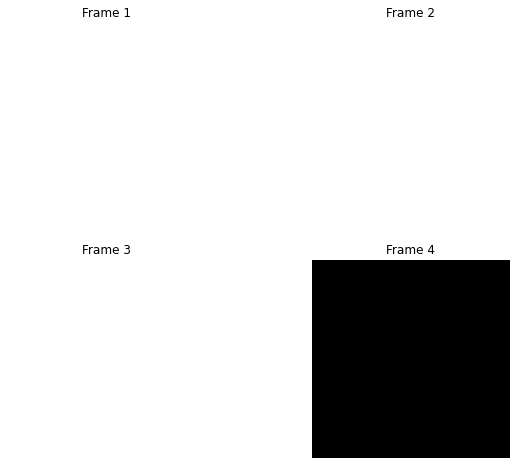

In [20]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X_data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    new_img = X_data[data_choice][idx]
    ax.imshow(np.squeeze(new_img))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [36]:
# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *X_train.shape[2:]))

# # We will construct 3 `ConvLSTM2D` layers with batch normalization,
# # followed by a `Conv3D` layer for the spatiotemporal outputs.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.Conv3D(
#     filters=3, kernel_size=(3, 3, 3), activation="softmax", padding="same"
# )(x)

# # Next, we will build the complete model and compile it.
# model = keras.models.Model(inp, x)
# model.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
# )

In [31]:
# # Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# # Define modifiable training hyperparameters.
# epochs = 5
# batch_size = 5

# # Fit the model to the training data.
# model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping, reduce_lr],
# )

Epoch 1/5


ValueError: in user code:

    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 4, 51, 51, 3) vs (None, 3)).


In [23]:
from keras.models import Sequential, Model 

batch_size = 100
epochs = 1

model = Sequential()
model.add(
    layers.ConvLSTM2D(
        filters = 64, 
        kernel_size = (3, 3), 
        return_sequences = False, 
        data_format = "channels_last", 
        input_shape = (4, 51, 51, 3)
    )
)
model.add(
    layers.Dropout(0.2)
)
model.add(
    layers.Flatten()
)
model.add(
    layers.Dense(256, activation="relu")
)
model.add(
    layers.Dropout(0.3)
)
model.add(
    layers.Dense(3, activation = "softmax")
)
 
model.summary()

#opt = keras.optimizers.SGD(lr=0.001)
opt = keras.optimizers.Adam()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
callbacks = [early_stopping, reduce_lr]
 
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 49, 49, 64)        154624    
                                                                 
 dropout_4 (Dropout)         (None, 49, 49, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 153664)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               39338240  
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 39,493,635
Trainable params: 39,493,635


In [28]:
y_pred = model.predict(X_test)

In [30]:
y_pred

array([[0.07264602, 0.8493258 , 0.07802824],
       [0.9753186 , 0.01641382, 0.00826761],
       [0.04599274, 0.55436516, 0.39964217],
       ...,
       [0.09036884, 0.54387844, 0.36575273],
       [0.26394713, 0.4346916 , 0.3013613 ],
       [0.03977095, 0.5872738 , 0.37295523]], dtype=float32)

In [31]:
from sklearn.metrics import classification_report

y_pred_ugly = y_pred.argmax(axis = 1)
y_test_ugly = y_test.argmax(axis = 1)
 
print(classification_report(y_test_ugly, y_pred_ugly[0:-1]))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1171
           1       0.61      0.92      0.73       800
           2       0.86      0.39      0.54       780

    accuracy                           0.75      2751
   macro avg       0.78      0.73      0.72      2751
weighted avg       0.79      0.75      0.74      2751



In [2]:
from DataBuilder import *

get_data()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/GoogleDrive/My Drive/TemporalData'

In [ ]:
amazonia_img_dir = '../data/Amazon' # directory where amazonia images are saved

cerrado_img_dir = '../data/Cerrado' # directory where cerrado images are saved

caatinga_img_dir = '../data/Caatinga' # directory where caatinga images are saved

# Get Amazonia triplets
amazonia_img_triplets = get_triplet_imgs(amazonia_img_dir, n_triplets=30000) 

# Get Cerrado triplets
cerrado_img_triplets = get_triplet_imgs(cerrado_img_dir, n_triplets=25000) 

# Get Amazonia
caatinga_img_triplets = get_triplet_imgs(caatinga_img_dir, n_triplets=25000)


print(cerrado_img_triplets[:5,:])

# ResNet

In [6]:
X_data = np.load('/Volumes/GoogleDrive/My Drive/ResNet18-2019-Training/train_data.npy')
y_data = np.load('/Volumes/GoogleDrive/My Drive/ResNet18-2019-Training/labels.npy')
#X_test = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Eval/Collated.npy')
#y_test = np.load('/Volumes/GoogleDrive/My Drive/TemporalData-Processed-Eval/labels.npy')

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

In [33]:
!pip install img2vec_pytorch

In [40]:
z_dim = 512
cuda = torch.cuda.is_available()
print (cuda)

False


In [46]:

def get_ResNet_Prediction(X_train):
    # Initialize Img2Vec with GPU
    img2vec = Img2Vec(cuda)

    UPSCALE = False
    t0 = time()

    X_pred = np.zeros((len(X_train), z_dim))

    for idx in range(len(X_train)):

        # Read in an image
        img = X_train[idx]

        # Upscale image
        if (UPSCALE):
            x, y, z = img.shape

            img = resize(img, (224, 224,z))
        
        im = Image.fromarray((img * 255).astype(np.uint8))   

        vec = img2vec.get_vec(im, tensor=True)
        
        new_vec = [x for x in vec[0]]

        X_pred[idx, :] = new_vec
        
        if (idx % 1000 == 0):
            print ("Progress: {:.2f}%".format(idx/len(X_train)*100))
            
    t1 = time()
    print('Embedded {} images: {:0.3f}s'.format(len(X_train), t1-t0))
    return X_pred

In [47]:
X_train_emb = get_ResNet_Prediction(X_train)
X_val_emb = get_ResNet_Prediction(X_val)

/Users/calummcmeekin/miniconda3/envs/tile2vec/lib/python3.8/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Progress: 0.00%
Embedded 44 images: 3.541s
Progress: 0.00%
Embedded 11 images: 0.892s


## Multinomial Logistic Regression

In [65]:
y_train_ugly = one_ugly_encoding(y_train)
y_val_ugly = one_ugly_encoding(y_val)
print (y_val_ugly)

[2 1 2 1 1 3 3 2 3 1 3]


In [69]:
n_trials = 1
accs = np.zeros((n_trials,))
precisions = np.zeros((n_trials,))
recalls = np.zeros((n_trials,))
fscores = np.zeros((n_trials,))

for i in range(n_trials):
    
    # Splitting data and training RF classifer
    # Define the multinomial logistic regression model    
    lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial'))
    
    # Fit the model on the whole dataset
    lr.fit(X_train_emb, y_train_ugly)
    
    accs[i] = lr.score(X_val_emb, y_val_ugly)
    
    y_pred = lr.predict(X_val_emb)
        
    precisions[i], recalls[i], fscores[i], _ = precision_recall_fscore_support(y_val_ugly, y_pred, average='macro')
    
    print ("TRIAL: {}".format(i))
    
print ("____Accuracy____")
print('Mean accuracy: {:0.4f}'.format(accs.mean()))
print('Standard deviation: {:0.4f}'.format(accs.std()))

print ("____Macro Precision____")
print('Mean macro precision: {:0.4f}'.format(precisions.mean()))
print('Standard deviation: {:0.4f}'.format(precisions.std()))

print ("____Macro Recall____")
print('Mean macro recall: {:0.4f}'.format(recalls.mean()))
print('Standard deviation: {:0.4f}'.format(recalls.std()))

print ("____Macro F1-Score____")
print('Mean macro F1-Score: {:0.4f}'.format(fscores.mean()))
print('Standard deviation: {:0.4f}'.format(fscores.std()))

TRIAL: 0
____Accuracy____
Mean accuracy: 0.6364
Standard deviation: 0.0000
____Macro Precision____
Mean macro precision: 0.6333
Standard deviation: 0.0000
____Macro Recall____
Mean macro recall: 0.6389
Standard deviation: 0.0000
____Macro F1-Score____
Mean macro F1-Score: 0.6111
Standard deviation: 0.0000
